<a href="https://colab.research.google.com/github/nidhaloff/model_params_keras/blob/master/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import keras
from keras import backend as K
from keras.layers import Dense, Flatten, Activation
from keras.activations import relu, sigmoid, tanh, softmax, linear
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# run keras model on google GPU

K.tensorflow_backend._get_available_gpus()
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [111]:
dataset = keras.datasets.boston_housing.load_data()
trainset, testset = dataset
X_train, y_train = trainset
X_test, y_test = testset
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(404, 13) (404,) (102, 13) (102,)


In [112]:
print(type(X_train))


<class 'numpy.ndarray'>


In [113]:
# check GPU 
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [114]:
X_df = pd.DataFrame(X_train)
y_df = pd.DataFrame(y_train)

X_test_df = pd.DataFrame(X_test)
y_test_df = pd.DataFrame(y_test)

print(X_df.shape, y_df.shape)

(404, 13) (404, 1)


In [115]:
df_train = pd.concat([X_df, y_df], axis=1)
df_test = pd.concat([X_test_df, y_test_df], axis=1)
print(df_train.shape, df_test.shape)

(404, 14) (102, 14)


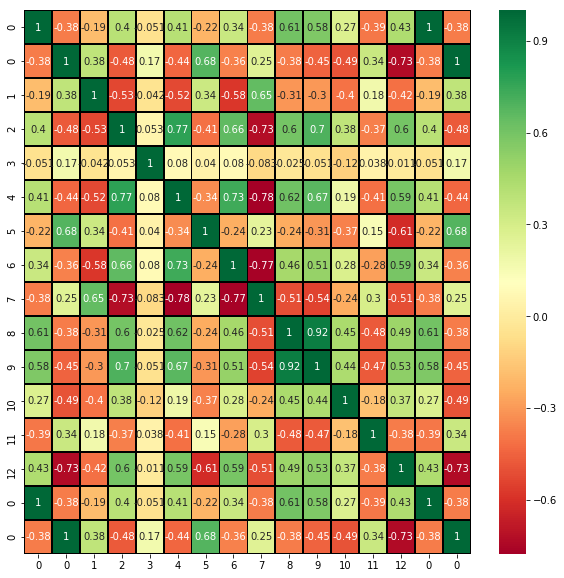

In [116]:
plt.figure(figsize=(10, 10))
corr_mat = df_train.corr()
top_corr_features = corr_mat.index
h_map = sns.heatmap(df_train[top_corr_features].corr(), linewidths=.7, linecolor='black', annot=True, cmap="RdYlGn")
h_map_fig = h_map.get_figure()
h_map_fig.savefig('h_map.jpg', dpi=400)

In [117]:
print(df_train.describe())
print(df_test.describe())

               0           1           2   ...          11          12          0 
count  404.000000  404.000000  404.000000  ...  404.000000  404.000000  404.000000
mean     3.745111   11.480198   11.104431  ...  354.783168   12.740817   22.395050
std      9.240734   23.767711    6.811308  ...   94.111148    7.254545    9.210442
min      0.006320    0.000000    0.460000  ...    0.320000    1.730000    5.000000
25%      0.081437    0.000000    5.130000  ...  374.672500    6.890000   16.675000
50%      0.268880    0.000000    9.690000  ...  391.250000   11.395000   20.750000
75%      3.674808   12.500000   18.100000  ...  396.157500   17.092500   24.800000
max     88.976200  100.000000   27.740000  ...  396.900000   37.970000   50.000000

[8 rows x 14 columns]
               0           1           2   ...          11         12          0 
count  102.000000  102.000000  102.000000  ...  102.000000  102.00000  102.000000
mean     3.092336   10.901961   11.264902  ...  364.163333   12.30

In [118]:
# df_train = (df_train - df_train.mean()) / df_train.std()
# df_test = (df_test - df_test.mean()) / df_test.std()
X_train = df_train.iloc[:, :-1]
y_train = df_train.iloc[:, -1]

X_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1]

X_train = (X_train - X_train.mean()) / X_train.std()
X_test = (X_test - X_test.mean()) / X_test.std()

X_train, X_test = X_train.to_numpy(), X_test.to_numpy()
y_train, y_test = y_train.to_numpy(), y_test.to_numpy()
# X_test = df_test.iloc[:, :-1]
# y_test = df_test.iloc[:, -1]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(404, 13) (404,)
(102, 13) (102,)


In [0]:
def create_model(layers, activation):
    model = keras.Sequential()
    for i, nodes in enumerate(layers):
        if i == 0:
            model.add(Dense(nodes, input_dim=X_train.shape[1]))
            model.add(Activation(activation))
        else:
            model.add(Dense(nodes))
            model.add(Activation(activation))
            
    model.add(Dense(1))
    
    model.compile(optimizer="rmsprop", loss="mse", metrics=["accuracy"])
    return model
       

In [120]:
model = KerasRegressor(build_fn=create_model, verbose=0)
print(model)

In [121]:
layers = [[20], [32, 64], [10, 5], [64, 32]]
activations = ['relu', 'tanh', 'sigmoid']
param_grid = dict(layers=layers, activation=activations, batch_size=[64, 100], epochs=[10])
print("param_gird: ", param_grid)

grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X_train, y_train)

param_gird:  {'layers': [[20], [32, 64], [10, 5], [64, 32]], 'activation': ['relu', 'tanh', 'sigmoid'], 'batch_size': [64, 100], 'epochs': [10]}


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [0]:
best_score, best_params = grid_result.best_score_, grid_result.best_params_

In [126]:
print(best_score)
print(best_params)

-330.97728438424593
{'activation': 'relu', 'batch_size': 64, 'epochs': 10, 'layers': [64, 32]}


In [124]:
grid.cv_results_


{'mean_fit_time': array([ 7.81494459,  7.71569085,  7.7547582 ,  8.00960978,  7.84087769,
         8.14247719,  8.39924224,  8.60085177,  8.68459153,  8.910513  ,
         8.98654842,  9.15657226,  9.00859253,  9.10927224,  9.13399959,
         9.48323862,  9.62162383, 10.20157893, 10.01144592, 10.06600976,
        10.00649325, 10.13832911, 10.33476686, 10.47282736]),
 'mean_score_time': array([3.06345884, 3.13621902, 3.13905366, 3.24691081, 3.28736242,
        3.31360324, 3.48775792, 3.51239618, 3.57776856, 3.59458963,
        3.70248334, 3.71808163, 3.7642405 , 3.72623674, 3.73470529,
        3.93506972, 3.96441579, 4.07443404, 4.11928344, 4.17813047,
        4.1874911 , 4.19118945, 4.3048021 , 4.33168006]),
 'mean_test_score': array([-523.06882076, -338.7690041 , -553.74887206, -330.97728438,
        -549.15748415, -407.79648107, -570.41261178, -404.33032499,
        -556.99301276, -479.79861208, -558.75300991, -475.17981508,
        -564.37900543, -509.89820137, -570.9198554 , -502